In [1]:
import numpy as np

from nfvm.mesh.triangleMesh import TriangleMesh
from nfvm.field.volField import volScalarField
import nfvm.fvm as fvm
import nfvm.fvc as fvc

import matplotlib.pyplot as plt

# 源项热平衡问题：显式源项
## 加载点和控制体

从文件 ../../resources/laplacian/heatCavity_tri/mesh/heatCavity.nfvm 加载网格信息 ...
文件版本：0.1.0
初始化 TriangleMesh ...
初始化 TriangleMesh 成功


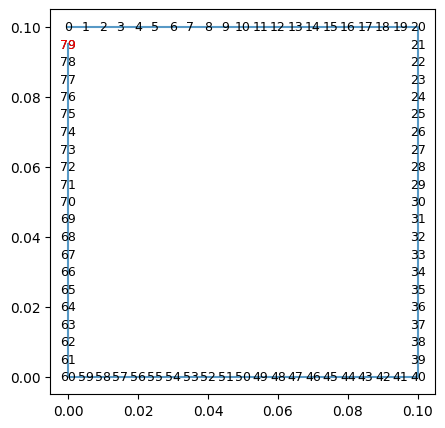

In [2]:
mesh = TriangleMesh.load("../../resources/laplacian/heatCavity_tri/mesh/heatCavity.nfvm")
mesh.showBoundary(pause=False)

## 构造一个温度场

In [3]:
# 构造一个边界条
k, b = np.ones(80), np.zeros(80)

# 20-40温度为310 
k[20:40] = 0.0
b[20:40] = 310.0
# 60-80温度为300，
k[60:80] = 0.0
b[60:80] = 290.0
# 0-20&40-60为绝热条件（0梯度条件），默认的 k=1.0, b=0.0就是0梯度

In [4]:
# 构造一个温度场并指定初始值

CN = mesh.cn
T = volScalarField("T", mesh, value=np.ones(CN)*300.0, boundary_dict={'k': k, 'b': b})

## 构造一个源项

In [5]:

q = volScalarField("q", mesh, value=np.zeros(CN))

# 下半部分为5
for i in range(mesh.cn):
    cx,cy = mesh.cell_center[i, :]
    r = ((cx-0.05)**2 + (cy-0.05)**2)**0.5
    if(r<0.01): # 中心热源
        q[i] = 1000*100

## 使用拉普拉斯算子构造稀疏矩阵

In [6]:
mat = (fvm.Laplacian(T) == fvc.Source(q))

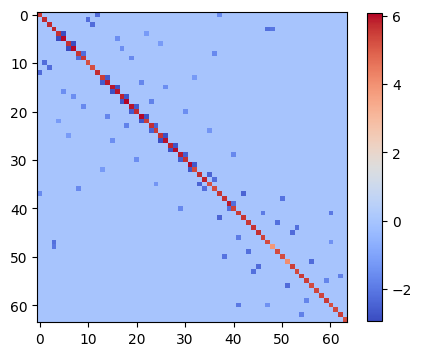

In [7]:
# 可视化稀疏矩阵
plt.figure(figsize=(5,5))

plt.imshow(mat.csr.todense()[:64,:64], cmap='coolwarm')
plt.colorbar(shrink=0.8)
# plt.savefig('sp-mat.png', dpi=150, bbox_inches='tight')
plt.show()

## 求解稀疏矩阵

使用`scipy.sparse.linalg`模块的`spsolve`函数求解稀疏矩阵。

In [8]:
x = mat.solve()

In [9]:
# 将计算结果写出到文件中

T.value = x
# T.writeVTK()

In [10]:
import matplotlib.tri as tri

In [11]:
X = mesh.points[:,0]
Y = mesh.points[:,1]
triangles = mesh.cells 

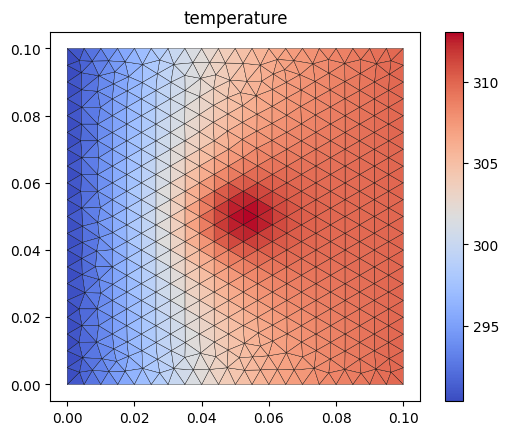

In [12]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
tpc = ax.tripcolor(X, Y, triangles, facecolors=T.value, cmap='coolwarm',  edgecolors='k')
fig.colorbar(tpc)
ax.set_title('temperature')

plt.show()